# Basic statistical analysis of time series

In this example, basic time series statistical analysis is demonstrated.

In [1]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

import evapy

## Generating a Gaussian stochastic signal

Lets start by generating a Gaussian time series signal. The duration is set to 3 hours and sampling rate is 10Hz. 

In [2]:
t = np.arange(0., 3*3600., 0.1)

The signal will be generated using a rectangular power spectrum between 5 and 15 seconds of period. It is important to use sufficiently many discretizations to obtain a non-repeating approximation. 

In [3]:
start_period = 15.
stop_period = 5.

discrete_size = 1000

In [4]:
amp_norm = stats.norm.rvs(size=discrete_size)
phase = stats.uniform.rvs(size=discrete_size)*2.*np.pi

signal_mean = 0.

In [5]:
freq = np.linspace(2.*np.pi*1./start_period, 2.*np.pi*1./stop_period, num=discrete_size)

Generating the signal by super-positioning a large number of cosine functions with stochastic amplitudes and phases.

In [6]:
signal = np.zeros(len(t)) + signal_mean

for i, freq_i in enumerate(freq):
    signal = signal + amp_norm[i]*np.cos(freq_i*t + phase[i])

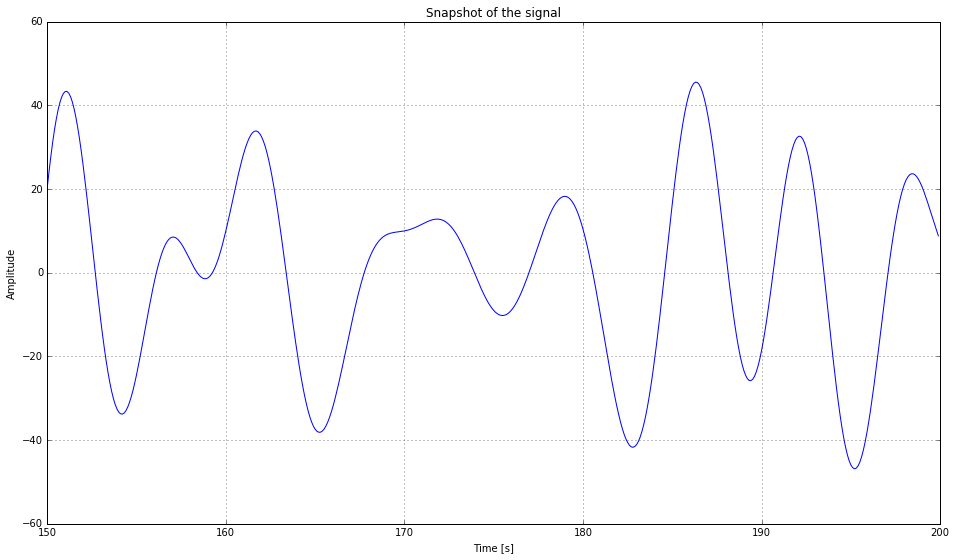

In [7]:
plt.figure('Snapshot of signal', figsize=(16,9))
plt.title('Snapshot of the signal')
plt.plot(t[1500:2000], signal[1500:2000])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

### Statistical analysis of the signal

Lets see if the signal resambles a Guassian signal with zero mean.

In [8]:
descr_stats = stats.describe(signal)

print 'mean: {}'.format(descr_stats.mean)
print 'std: {}'.format(np.sqrt(descr_stats.variance))
print 'skewness: {}'.format(descr_stats.skewness)

mean: -0.000945859982877
std: 22.5069246137
skewness: 0.00555529296621


Estimate the normal distribution paramters from data and plot the normal pdf with the histogram for data.

In [9]:
params = stats.norm.fit(signal)
signal_dist = stats.norm(*params)

In [10]:
x = np.linspace(-100, 100, num=200)

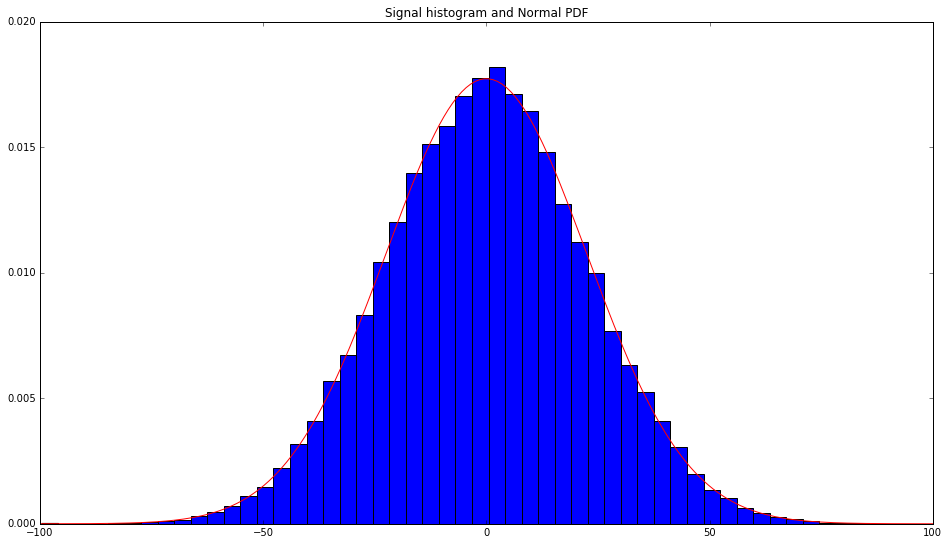

In [11]:
plt.figure('Signal histogram', figsize=(16,9))
plt.title('Signal histogram and Normal PDF')
plt.plot(x, signal_dist.pdf(x), color='r')
plt.hist(signal, bins=50, normed=True)
plt.show()

It is clear that the signal is indeed Gaussian!

### Extreme value analysis

#### Finding the peaks

``evapy`` package provides robust and fast methods to identify upcrossings and peaks. The declustered peaks refer to the largest peak per upcrossing. hus, for a narrow-banded signal, all peaks are declustered. In this example, declustering will occur for mean-upcrossing.

In [12]:
peak_index = evapy.evstats.argrelmax(signal)
peak = signal[peak_index]

peak_dc_index = evapy.evstats.argrelmax_decluster(signal, x_up=np.mean(signal))
peak_dc = signal[peak_dc_index]

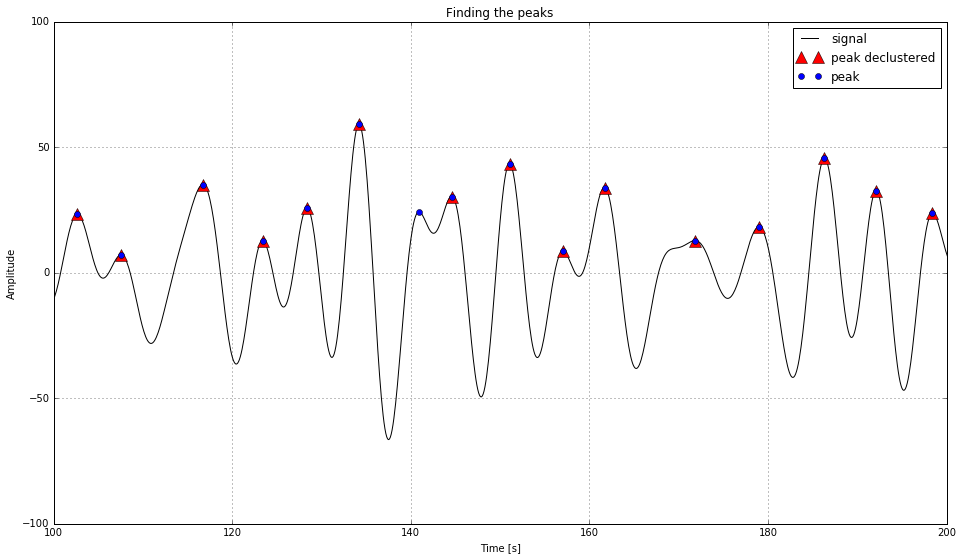

In [13]:
plt.figure('Finding the peaks', figsize=(16,9))
plt.title('Finding the peaks')
plt.plot(t, signal, 'k-', label='signal')
plt.plot(t[peak_dc_index], peak_dc, 'r^', markersize=12, label='peak declustered')
plt.plot(t[peak_index], peak, 'bo', label='peak')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(100,200)
plt.grid()
plt.legend()
plt.show()

#### Counting upcrossings

Lets find the number of upcrossings for different levels using the ``evapy`` package.

In [14]:
uc_0 = evapy.evstats.argupcross(signal, x_up=np.mean(signal))

print('number of upcrossings above the mean: {}'.format(len(uc_0)))

number of upcrossings above the mean: 1511


Since the signal is 10800 seconds long, this mean that the Tz ((mean or) zero crossing period) of the signal is

In [15]:
t[-1]/len(uc_0)

7.1475181998676387

Now, lets find the upcrossing rate at mean+std level.

In [16]:
uc_1 = evapy.evstats.argupcross(signal, x_up=np.mean(signal)+np.std(signal))

In [17]:
print('number of upcrossings above the mean+std: {}'.format(len(uc_1)))

number of upcrossings above the mean+std: 917


The upcrossing rate is then:

In [18]:
len(uc_1)/t[-1]

0.084908193594385117

#### Statistical analysis of peaks

Now that we have established the peaks, lets investigate their distribution. Using different distribution functions the ``evapy`` package offers.

In [19]:
eak_index = evapy.evstats.argrelmax(signal)
peak = signal[peak_index]

peak_dc_index = evapy.evstats.argrelmax_decluster(signal, x_up=np.mean(signal))
peak_dc = signal[peak_dc_index]

r = np.linspace(-10, 100, num=100)

Using Rayleigh distribution:

In [20]:
params_ray = evapy.distributions.rayleigh.fit(peak_dc)
peak_dc_ray = evapy.distributions.rayleigh(*params_ray)

In [21]:
print('location: {}'.format(params_ray[0]))
print('scale: {}'.format(params_ray[1]))

location: -2.00379772903
scale: 23.5855365214


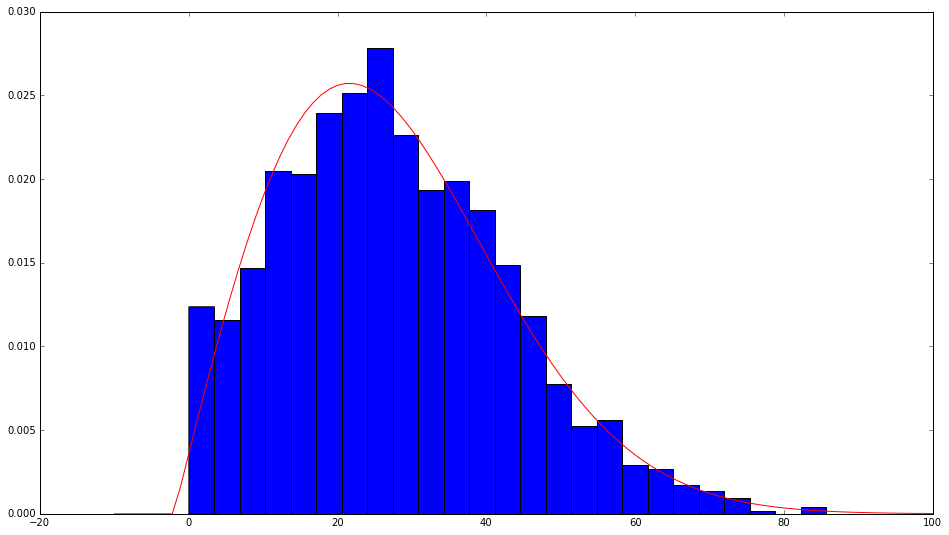

In [22]:
plt.figure('Peaks histogram and Rayleigh distribution', figsize=(16,9))
plt.plot(r, peak_dc_ray.pdf(r), color='r')
plt.hist(peak_dc, bins=25, normed=True)
plt.show()

Using the Weibull distribution:

**Note**: Sometimes, the estimation alogorithm fails if the starting values for scale parameter is too far off. This is a known issue and we are working on it. In the mean time, you may provice a reasonable starting value for the scale parameter.

In [23]:
params_wb = evapy.distributions.weibull.fit(peak_dc, scale=20.)
peak_dc_wb = evapy.distributions.weibull(*params_wb)

In [24]:
print('shape: {}'.format(params_wb[0]))
print('location: {}'.format(params_wb[1]))
print('scale: {}'.format(params_wb[2]))

shape: 2.01183853091
location: -2.0901629682
scale: 33.4718131171


The shape parameter should be close to 2. Sometimes the estimation alogorithm fails and divereges  for 3 parameter Weibull using the MLE.

Lets see how the histogram looks.

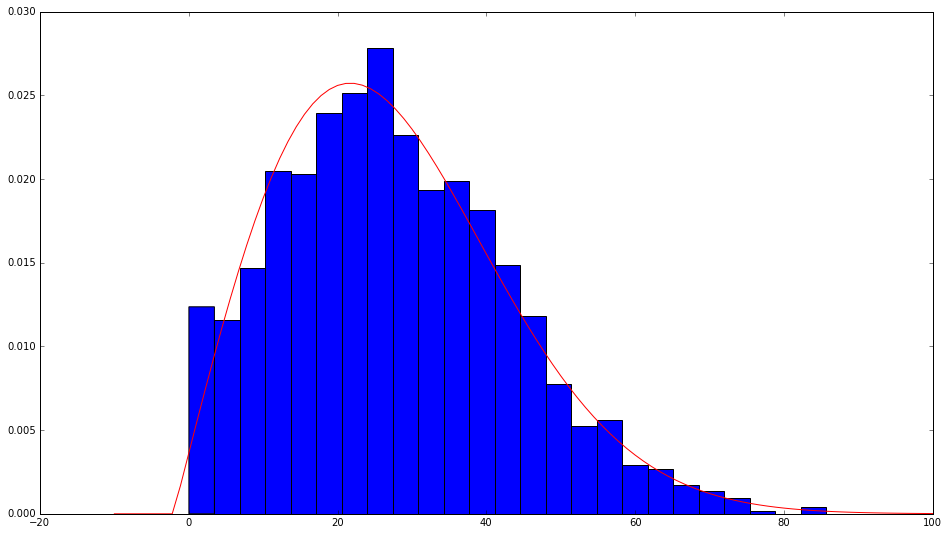

In [25]:
plt.figure('Peaks histogram and Weibull distribution', figsize=(16,9))
plt.plot(r, peak_dc_wb.pdf(r), color='r')
plt.hist(peak_dc, bins=25, normed=True)
plt.show()

Often, the to provide a good starting value for the scale parameter. Or to lock the location parameter based on prior knowledge. In our case, the signal mean can be a reasonable choice.

In [26]:
params_wb = evapy.distributions.weibull.fit(peak_dc, floc=np.mean(signal))
peak_dc_wb = evapy.distributions.weibull(*params_wb)

In [27]:
print('shape: {}'.format(params_wb[0]))
print('location: {}'.format(params_wb[1]))
print('scale: {}'.format(params_wb[2]))

shape: 1.78858847769
location: -0.000945859982877
scale: 30.8242364183


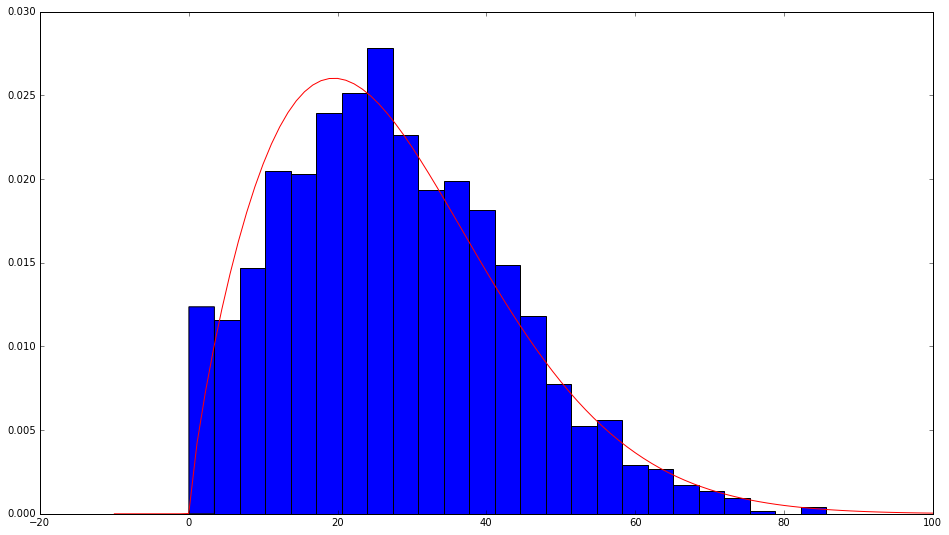

In [28]:
plt.figure('Peaks histogram and Weibull distribution', figsize=(16,9))
plt.plot(r, peak_dc_wb.pdf(r), color='r')
plt.hist(peak_dc, bins=25, normed=True)
plt.show()

Using the generalized exponential tail distribution:

Note that the generalized exponential tail distribution is particularly suitable for truncated data. Lets truncate our peak data at 35.

In [29]:
peak_dc_trunc = peak_dc[peak_dc>=35.]

We have now discareded most of our data:

In [30]:
print('original data size: {}'.format(len(peak_dc)))
print('truncated data size: {}'.format(len(peak_dc_trunc)))

original data size: 1510
truncated data size: 464


**WARNING**: At this point, the estimation alogrithm for the generalized exponential tail distribution is very unstable. It is recommended to lock the location parameter and provide a good starting value for the scale parameter. We are working on it!

In [31]:
params_get = evapy.distributions.genexptail.fit(peak_dc_trunc, scale=20., floc=np.mean(signal))
peak_dc_get = evapy.distributions.genexptail(*params_get)

In [32]:
print('shape: {}'.format(params_get[0]))
print('q: {}'.format(params_get[1]))
print('location: {}'.format(params_get[2]))
print('scale: {}'.format(params_get[3]))

shape: 2.03843462953
q: 3.21933597547
location: -0.000945859982877
scale: 32.1651332225


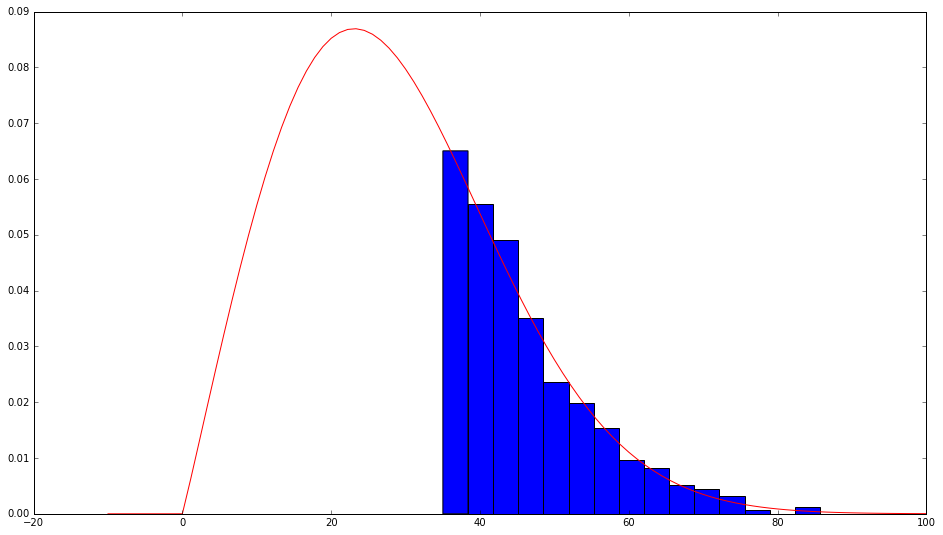

In [33]:
plt.figure('Peaks histogram and generalized exponential tail distribution', figsize=(16,9))
plt.plot(r, peak_dc_get.pdf(r), color='r')
plt.hist(peak_dc_trunc, bins=15, normed=True)
plt.show()

#### Estimating the largest maxima

We can use the the relationship between the peak distributions and the maxima distributions to establish an estimate for the largest maxima. First, lets see whats the largest observed value in our signal.

In [34]:
max_obs = np.max(signal)
print('largest maxima: {}'.format(max_obs))

largest maxima: 85.7084061456


Using Rayleig:

In [35]:
rloc, rscale = evapy.distributions.rayleigh.fit(peak_dc, floc=0.)
rN = len(peak_dc)

In [36]:
maxima_ray_dist = evapy.distributions.acer_o1(2., rN, loc=rloc, scale=np.sqrt(2.)*rscale)

In [37]:
median_maxima = maxima_ray_dist.ppf(0.5)
print('median maxima: {}'.format(median_maxima))

median maxima: 87.5809613038


Using Weibull:

In [38]:
wshape, wloc, wscale = evapy.distributions.weibull.fit(peak_dc, floc=0.)
wN = len(peak_dc)

In [39]:
maxima_wb_dist = evapy.distributions.acer_o1(wshape, wN, loc=wloc, scale=wscale)

In [40]:
median_maxima = maxima_wb_dist.ppf(0.5)
print('median maxima: {}'.format(median_maxima))

median maxima: 96.4126347017


Using generalized exponential tail:

In [41]:
gshape, qn, gloc, gscale = evapy.distributions.genexptail.fit(peak_dc_trunc, floc=0., scale=20.)
gN = len(peak_dc_trunc)

2.03841302636 3.21927276457 0.0 32.1644965197


In [42]:
maxima_get_dist = evapy.distributions.acer_o1(gshape, gN*qn, loc=gloc, scale=gscale)

In [43]:
median_maxima = maxima_get_dist.ppf(0.5)
print('median maxima: {}'.format(median_maxima))

median maxima: 87.4161823975
